# Exploratory Data Analysis
### Purpose
The purpose of this notebook is to explore the Audubon circle and NOAA data.
This notebook addresses some one of the tasks in Github issue #36

### Author: 
Ian Davis
### Date: 
2020-02-17
### Update Date: 
2020-05-13

### Inputs 
1.3-rec-connecting-fips-ecosystem-data.csv - Comma separate file of the Christmas Bird Count and matches to 1 or more NOAA weather stations.
- Data Dictonary can be found here: http://www.audubon.org/sites/default/files/documents/cbc_report_field_definitions_2013.pdf

### Output Files
None

## Steps or Proceedures in the notebook 
- Set runtime options
- Import data and do initial counts
- Screen the data
- Check for Outliers
- Summary statistics and simple visualizations

## References
- elevation change and temperature: https://sciencing.com/info-8686864-latitude-altitude-affect-temperature.html

### See data dictionary: 

http://www.audubon.org/sites/default/files/documents/cbc_report_field_definitions_2013.pdf

In [1]:
import numpy as np
import pandas as pd
import plotly_express as px
import matplotlib.pyplot as plt
import datetime
from scipy import stats
import sys

# add scripts folder to path
sys.path.insert(1, '../scripts')

# user import
from calcs import main_calcs

pd.set_option('display.max_columns', 500)

## Set File Paths and Runtime Options

In [2]:
#PATH_TO_PAIRED_DATA = '../data/Cloud_data/1.2-ijd-fetch-circle-elevations_20200502155633.csv'
PATH_TO_PAIRED_DATA = '../data/Cloud_data/1.3-rec-connecting-fips-ecosystem-data.txt'

## Read in Data

In [3]:
# Read in unfinished dataset
df_paired = pd.read_csv(PATH_TO_PAIRED_DATA, compression='gzip')

## Calculated Variables

In [4]:
df_paired = main_calcs(df_paired)

## Data Screening

Are there indeces which have negative values for both CBC and NOAA?

In [5]:
df_paired.loc[((df_paired.loc[:, 'min_temp'] < 0.0) & 
               (df_paired.loc[:, 'noaa_tmin_value'] < 0.0))].index.size

1900

Any negative temperatures in Florida?<br>
Lat: 25 to 30<br>
Long: -80 to -90

In [6]:
df_paired.loc[((df_paired.loc[:, 'noaa_tmin_value'] < 0.0) &
               (df_paired.loc[:, 'latitude'] < 30.0) &
               (df_paired.loc[:, 'longitude'] > -90.0))].index.size

0

Screen stations with obvious temperature errors:<br>
- tmin no less than -100 degF
- tmax no greater than 150 degFa
- (probably could be more strict, but this is first guess)

In [7]:
print('Minimum tmin for circles:', df_paired['min_temp'].min())
print('Minimum tmin for NOAA stations:', df_paired['noaa_tmin_value'].min())
print('Minimum tmax for circles:', df_paired['max_temp'].max())
print('Minimum tmax for NOAA stations:', df_paired['noaa_tmax_value'].max())

Minimum tmin for circles: -51.0
Minimum tmin for NOAA stations: -58.0
Minimum tmax for circles: 93.0
Minimum tmax for NOAA stations: 140.0


Are there any 'min_snow' values larger than 'max_snow' ?

In [8]:
print('Number of rows:', df_paired.loc[(df_paired.loc[:, 'min_snow'] > df_paired.loc[:, 'max_snow'])].index.size)
print(df_paired.loc[(df_paired.loc[:, 'min_snow'] > df_paired.loc[:, 'max_snow']), ['circle_name', 'count_date', 'min_snow', 'max_snow']])

Number of rows: 7
                 circle_name  count_date  min_snow  max_snow
80890                Caribou  2011-12-28       4.0       1.0
80910           Presque Isle  2011-12-31       2.0       1.0
81751  Angel Fire-Eagle Nest  2011-12-18      12.0       3.0
83338               Waukesha  2011-12-17       5.0       1.0
83339               Waukesha  2011-12-17       5.0       1.0
83340               Waukesha  2011-12-17       5.0       1.0
83341               Waukesha  2011-12-17       5.0       1.0


In [9]:
# Sometimes the rain or snow intensity is listed as "2,1"
# And somewhere along the line these were converted to floats: 32.0 = 3,2 ...probably?
df_paired.loc[:, 'am_rain'].value_counts()

3.0      60171
4.0      21026
2.0       9284
1.0       1344
32.0       716
21.0       636
321.0      239
31.0        19
12.0         6
123.0        1
23.0         1
34.0         1
Name: am_rain, dtype: int64

Rows that contain precipitation values:

In [10]:
df_paired.loc[(df_paired.loc[:, 'cbc_is_prec'] == True)].index.size

94379

Check for false positives:

In [11]:
df_paired.loc[(df_paired.loc[:, 'cbc_is_prec'] == True) &
              (pd.isna(df_paired.loc[:, 'min_snow']) &
               pd.isna(df_paired.loc[:, 'max_snow']) &
               pd.isna(df_paired.loc[:, 'am_rain']) &
               pd.isna(df_paired.loc[:, 'pm_rain'])),
              ['cbc_is_prec', 'min_snow', 'max_snow', 'am_rain', 'pm_rain']].head(10)

,cbc_is_prec,min_snow,max_snow,am_rain,pm_rain


Absolute Temperature Difference:

In [12]:
print('Largest temp difference for tmax between circles and stations:', df_paired['tmax_diff_abs'].max())
print('Largest temp difference for tmin between circles and stations:', df_paired['tmin_diff_abs'].max())

Largest temp difference for tmax between circles and stations: 92.08
Largest temp difference for tmin between circles and stations: 83.0


<br>
Histogram of tmax absolute difference values:

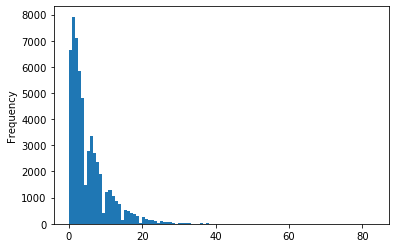

In [13]:
df_paired.loc[:, 'tmin_diff_abs'].plot.hist(bins=100)

Histogram of tmin absolute difference values:

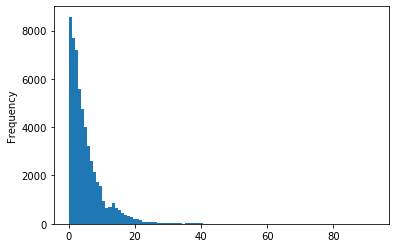

In [14]:
df_paired.loc[:, 'tmax_diff_abs'].plot.hist(bins=100)

Mean temperature difference:

In [15]:
# mean temperature difference
tmin_diff_mean = df_paired.loc[:, 'tmin_diff_abs'].mean(skipna=True)
tmin_diff_std = df_paired.loc[:, 'tmin_diff_abs'].std(skipna=True)
tmax_diff_mean = df_paired.loc[:, 'tmax_diff_abs'].mean(skipna=True)
tmax_diff_std = df_paired.loc[:, 'tmax_diff_abs'].std(skipna=True)

print('Tmin Difference Mean & SD:', round(tmin_diff_mean,2), ', ', round(tmin_diff_std,2))
print('Tmax Difference Mean & SD:', round(tmax_diff_mean,2), ', ', round(tmax_diff_std,2))

Tmin Difference Mean & SD: 5.28 ,  5.52
Tmax Difference Mean & SD: 5.05 ,  5.71


## Outliers



Screen stations further than 10 km:

In [16]:
df_paired_10k = df_paired.loc[(df_paired.loc[:, 'distance'] <= 10000.0), :]
print('Rows in original dataset:', df_paired.index.size)
print('Rows in 10km dataset:', df_paired_10k.index.size)

Rows in original dataset: 109390
Rows in 10km dataset: 55374


### ** THAT'S A BIG DROP OFF **

Mean temperature difference:

In [17]:
tmin_diff_mean = df_paired_10k.loc[:, 'tmin_diff_abs'].mean(skipna=True)
tmin_diff_std = df_paired_10k.loc[:, 'tmin_diff_abs'].std(skipna=True)
tmax_diff_mean = df_paired_10k.loc[:, 'tmax_diff_abs'].mean(skipna=True)
tmax_diff_std = df_paired_10k.loc[:, 'tmax_diff_abs'].std(skipna=True)

print('Tmin Difference Mean & SD:', round(tmin_diff_mean,2), ', ', round(tmin_diff_std,2))
print('Tmax Difference Mean & SD:', round(tmax_diff_mean,2), ', ', round(tmax_diff_std,2))

Tmin Difference Mean & SD: 5.08 ,  5.54
Tmax Difference Mean & SD: 4.83 ,  5.69


<br>
Box & Whisker Plots:<br>

Tmin & Tmax Difference

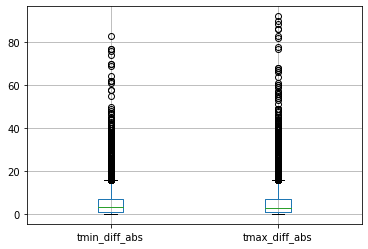

In [18]:
df_paired_10k.boxplot(column=['tmin_diff_abs', 'tmax_diff_abs'])

Clearly, there are some actual errors here. Not just outliers.

In [19]:
df_paired_10k.loc[(df_paired_10k.loc[:, 'tmin_diff_abs'].nlargest(20)).index,
                  ['circle_name', 'count_date', 'distance', 'min_temp', 'noaa_tmin_value', 'tmin_diff_abs']]

,circle_name,count_date,distance,min_temp,noaa_tmin_value,tmin_diff_abs
55754,Chincoteague N.W.R.,2003-12-28,4046.893371,30.0,113.00,83.00
79406,Malibu,2011-12-18,7076.027897,45.0,-32.08,77.08
63823,Santa Cruz Island,2007-12-17,9573.838063,22.0,-54.94,76.94
51061,Sisters,2001-12-16,3854.408652,22.0,98.06,76.06
63679,Crystal Springs,2007-12-15,7299.333140,42.0,-32.08,74.08
60942,Crystal Springs,2006-12-16,7299.333140,38.0,-32.08,70.08
11463,Kaua'i: Kapa'a,1973-12-31,9421.868369,0.0,69.98,69.98
49920,Ukiah,2001-12-15,8101.500452,32.0,100.94,68.94
63663,Calaveras,2008-01-05,9483.063229,32.0,-32.08,64.08
60926,Calaveras,2006-12-30,9483.063229,30.0,-32.08,62.08


Calculate z-scores:

In [20]:
df_paired_10k.loc[:, 'tmin_diff_z'] = stats.zscore(df_paired_10k.loc[:, 'tmin_diff_abs'], nan_policy='omit')
df_paired_10k.loc[:, 'tmax_diff_z'] = stats.zscore(df_paired_10k.loc[:, 'tmax_diff_abs'], nan_policy='omit')

c:\users\ijd50\appdata\local\programs\python\python37-32\lib\site-packages\pandas\core\indexing.py:376: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

c:\users\ijd50\appdata\local\programs\python\python37-32\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Histogram of z-scores for tmin:

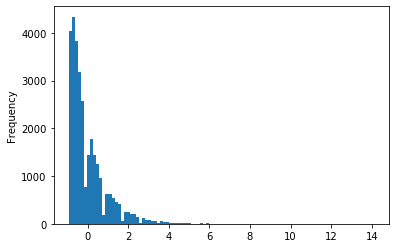

In [21]:
df_paired_10k.loc[:, 'tmin_diff_z'].plot.hist(bins=100)

Eliminate outliers (z > 2.96):

In [22]:
df_paired_noout = df_paired_10k.loc[((df_paired_10k.loc[:, 'tmin_diff_z'].abs() < 2.96) &
                                     (df_paired_10k.loc[:, 'tmax_diff_z'].abs() < 2.96))]

print('Rows in 10km temp-screened dataset:', df_paired_10k.index.size)
print('Rows in no outlier dataset:', df_paired_noout.index.size)

Rows in 10km temp-screened dataset: 55374
Rows in no outlier dataset: 29281


Show box & whisker plots again:

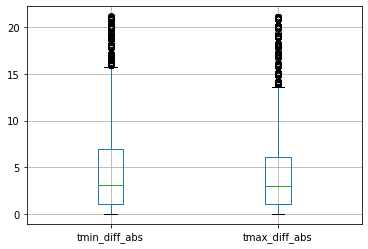

In [23]:
df_paired_noout.boxplot(column=['tmin_diff_abs', 'tmax_diff_abs'])

## Counting:

In [24]:
df_paired.loc[:, 'id'].value_counts()
station_list = df_paired.loc[:, 'id'].unique()
print('Number of unique NOAA stations:', len(station_list))

Number of unique NOAA stations: 11652


In [25]:
print('Total number of rows in the dataset:\n')
print('Original dataset:', df_paired.index.size)
print('Circle-to-NOAA distance under 10km:', df_paired_10k.index.size)
print('Outliers removed based on temperature:', df_paired_noout.index.size)

Total number of rows in the dataset:

Original dataset: 109390
Circle-to-NOAA distance under 10km: 55374
Outliers removed based on temperature: 29281


How many records have CBC data but not NOAA data?

In [26]:
print('tmin:', df_paired.loc[pd.isnull(df_paired.loc[:, 'min_temp']) &
                             pd.isna(df_paired.loc[:, 'noaa_tmin_value'])].index.size)
print('tmax:', df_paired.loc[pd.isnull(df_paired.loc[:, 'max_temp']) &
                             pd.isna(df_paired.loc[:, 'noaa_tmax_value'])].index.size)
print('precipitation:', df_paired.loc[(df_paired.loc[:, 'cbc_is_prec'] == True) &
                             (df_paired.loc[:, 'precipitation_value'] == 0)].index.size)

tmin: 5929
tmax: 5942
precipitation: 63874


How many states are included in the CBC counts?

In [27]:
print(df_paired['country_state'].unique())
print('Count:', len(df_paired['country_state'].unique()))
print('\n')
print('Value counts:\n', df_paired['country_state'].value_counts())

['US-CA' 'US-CO' 'US-CT' 'US-IL' 'US-LA' 'US-MA' 'US-MO' 'US-NJ' 'US-NY'
 'US-OH' 'US-PA' 'US-WI' 'US-DC' 'US-RI' 'US-IN' 'US-KY' 'US-MI' 'US-NC'
 'US-NH' 'US-NM' 'US-SC' 'US-TN' 'US-VT' 'US-FL' 'US-GA' 'US-IA' 'US-UT'
 'US-WA' 'US-KS' 'US-VA' 'US-WV' 'US-ME' 'US-MN' 'US-SD' 'US-DE' 'US-MS'
 'US-ID' 'US-NE' 'US-AZ' 'US-MD' 'US-AR' 'US-MT' 'US-ND' 'US-OK' 'US-TX'
 'US-OR' 'US-AL' 'US-AK' 'US-HI' 'US-NV' 'US-WY']
Count: 51


Value counts:
 US-CA    9230
US-TX    6466
US-CO    5846
US-NY    5400
US-PA    4966
US-IL    3780
US-WI    3581
US-NC    3501
US-NJ    3416
US-FL    3142
US-OH    2900
US-MA    2893
US-OR    2835
US-HI    2789
US-MI    2565
US-NM    2330
US-WA    2323
US-AZ    2304
US-IN    2269
US-VA    2221
US-MN    2042
US-TN    1921
US-MD    1772
US-MO    1729
US-MT    1693
US-UT    1611
US-IA    1592
US-KS    1467
US-AK    1383
US-WY    1307
US-CT    1275
US-NH    1222
US-SC    1191
US-AR    1098
US-ID    1096
US-OK    1079
US-VT    1046
US-ME    1012
US-WV     953
US-LA     92

Histogram of years:

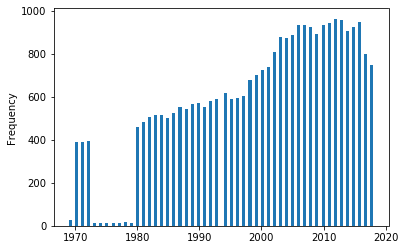

In [28]:
df_paired_noout.loc[:, 'count_year'].plot.hist(bins=100)

In [29]:
print('Furthest year back after screening:', df_paired_noout['count_year'].min())

Furthest year back after screening: 1969


Histogram of years before screening:

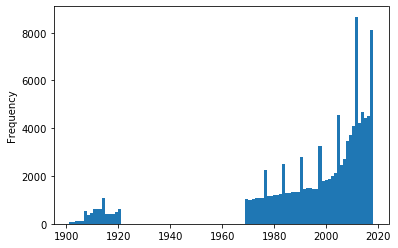

In [30]:
df_paired.loc[:, 'count_year'].plot.hist(bins=100)

Histogram of station distances:

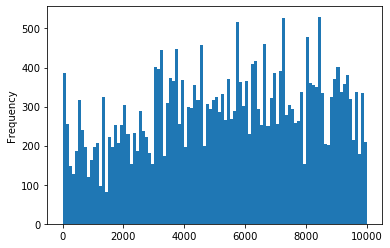

In [31]:
df_paired_noout.loc[:, 'distance'].plot.hist(bins=100)

Histogram of difference in elevations:

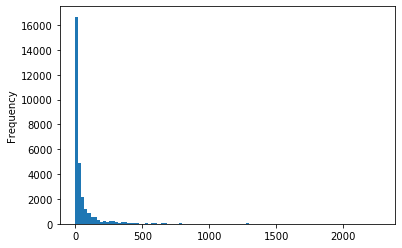

In [32]:
df_paired_noout.loc[:, 'elev_diff'].plot.hist(bins=100)

Scatter plot of station distance with mean temperature difference:

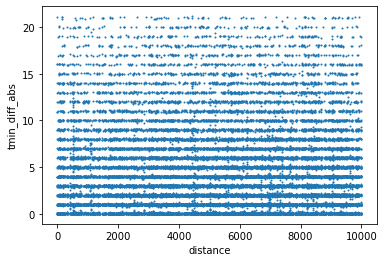

In [33]:
df_paired_noout.plot.scatter(x='distance',
                             y='tmin_diff_abs',
                             s=1)

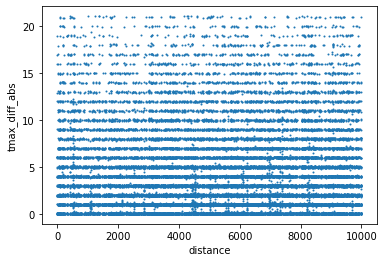

In [34]:
df_paired_noout.plot.scatter(x='distance',
                             y='tmax_diff_abs',
                             s=1)

### Best Matching Data

Smallest differences: (tmin)

In [35]:
df_paired_noout.loc[(df_paired_noout.loc[:, 'tmin_diff_abs'].nsmallest(20)).index,
                  ['circle_name', 'count_date', 'distance', 'elev_diff','min_temp', 'noaa_tmin_value', 'tmin_diff_abs']]

,circle_name,count_date,distance,elev_diff,min_temp,noaa_tmin_value,tmin_diff_abs
7107,Chaco Canyon N.M.,1969-01-01,1087.363882,74.56,-4.0,-4.0,0.0
7271,Santa Rosa,1969-12-21,1996.855621,0.13,50.0,50.0,0.0
7307,Litchfield Hills,1969-12-21,5537.718305,27.87,5.0,5.0,0.0
7715,Elmira,1970-01-01,4466.549054,4.34,-4.0,-4.0,0.0
7789,Lakewood,1969-12-21,5245.357885,10.20,14.0,14.0,0.0
7955,Fort Worth,1969-12-27,2012.241845,27.40,50.0,50.0,0.0
7990,Kanab,1969-12-21,1801.622106,16.17,32.0,32.0,0.0
8266,Grand Junction,1970-12-27,6063.531446,80.08,14.0,14.0,0.0
8590,Stevensville,1970-12-26,109.268188,16.39,5.0,5.0,0.0
9114,Little Rock,1972-01-02,5043.492521,2.52,41.0,41.0,0.0


Smallest differences: (tmax)

In [36]:
df_paired_noout.loc[(df_paired_noout.loc[:, 'tmax_diff_abs'].nsmallest(20)).index,
                  ['circle_name', 'count_date', 'distance', 'elev_diff','max_temp', 'noaa_tmax_value', 'tmax_diff_abs']]

,circle_name,count_date,distance,elev_diff,max_temp,noaa_tmax_value,tmax_diff_abs
7103,Des Lacs N.W.R.,1969-01-01,2279.091169,45.45,5.0,5.0,0.0
7105,Grand Forks-East Grand Forks,1969-01-01,4354.874073,4.71,-4.0,-4.0,0.0
7176,Pipe Spring N.M.,1969-12-22,41.755152,10.68,59.0,59.0,0.0
7215,Los Baños,1969-12-30,8890.081383,85.13,50.0,50.0,0.0
7388,Burlington,1969-12-28,5601.950357,8.44,32.0,32.0,0.0
7430,Springfield,1969-12-28,5753.726056,0.61,32.0,32.0,0.0
7441,Terre Haute,1969-12-29,6036.514953,5.46,32.0,32.0,0.0
7529,Eastport,1969-12-26,535.256614,15.60,32.0,32.0,0.0
7598,Natchez,1969-12-20,4774.290981,16.22,50.0,50.0,0.0
7913,Waubay N.W.R.,1969-12-24,21.320167,0.45,32.0,32.0,0.0


How many rows contain temperature difference off less than 1 degree?

In [37]:
print('tmax:', df_paired_noout.loc[df_paired_noout['tmax_diff_abs'] < 1.0].index.size)
print('tmin:', df_paired_noout.loc[df_paired_noout['tmin_diff_abs'] < 1.0].index.size)
df_paired_noout_1deg = df_paired_noout.loc[df_paired_noout['tmax_diff_abs'] < 1.0]

tmax: 6643
tmin: 5864


For rows with less than 1 deg difference (tmax), look at the distribution of years. Increasing trend probably due to more volunteers over the years.

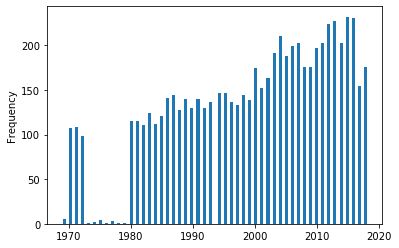

In [38]:
df_paired_noout_1deg.loc[:, 'count_year'].plot.hist(bins=100)

Look at distribution of latitudes:

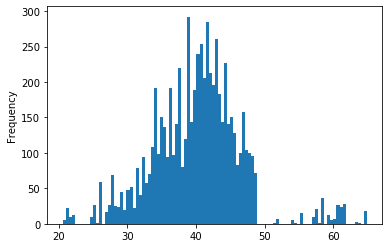

In [39]:
df_paired_noout_1deg.loc[:, 'lat'].plot.hist(bins=100)

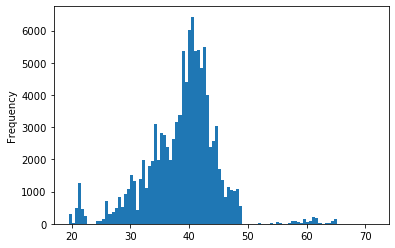

In [40]:
df_paired.loc[:, 'lat'].plot.hist(bins=100)

Distribution of longitudes:

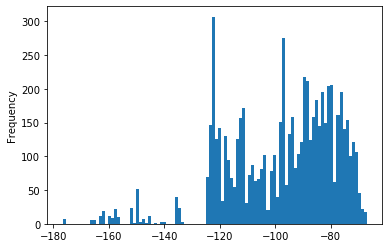

In [41]:
df_paired_noout_1deg.loc[df_paired_noout_1deg['lon'] < 0.0, 'lon'].plot.hist(bins=100)

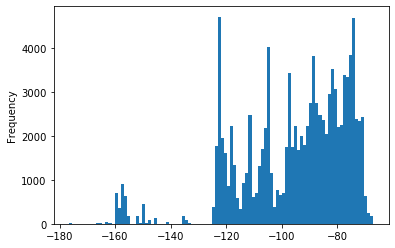

In [42]:
df_paired.loc[df_paired['lon'] < 0.0, 'lon'].plot.hist(bins=100)

For smallest temperature differences, look at distance distribution. Still a uniform distribution.

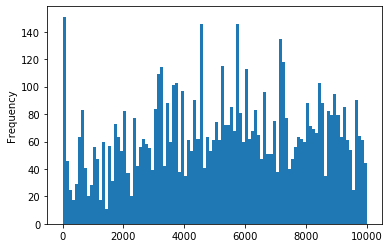

In [43]:
df_paired_noout_1deg.loc[:, 'distance'].plot.hist(bins=100)

For smallest temperature differences, look at elevation difference distribution.

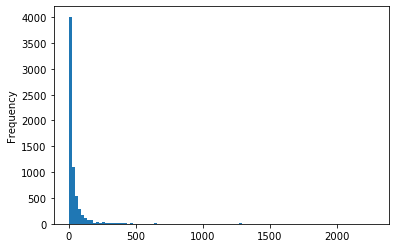

In [44]:
df_paired_noout_1deg.loc[:, 'elev_diff'].plot.hist(bins=100)

Less than 500 m elevation difference:

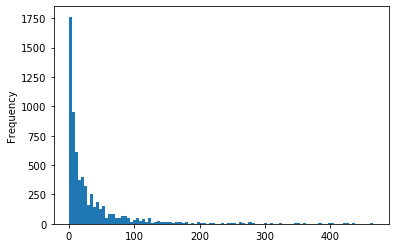

In [45]:
df_paired_noout_1deg.loc[df_paired_noout_1deg['elev_diff'] < 500.0, 'elev_diff'].plot.hist(bins=100)

Relationship between tmax difference and elevation change:

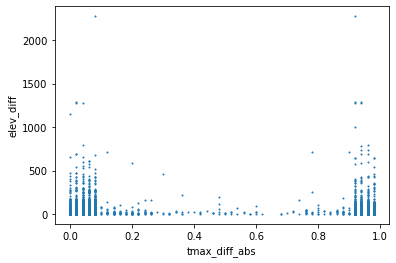

In [46]:
df_paired_noout_1deg.plot.scatter(x='tmax_diff_abs',
                                  y='elev_diff',
                                  s=1)

- I think we see this "step change" like splits because a lot of volunteers probably measured data using 

Relationship between tmax difference and distance:

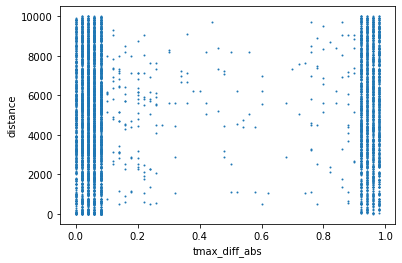

In [47]:
df_paired_noout_1deg.plot.scatter(x='tmax_diff_abs',
                                  y='distance',
                                  s=1)

Relationship between tmax difference and latitude:

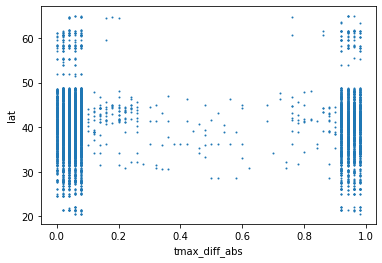

In [48]:
df_paired_noout_1deg.plot.scatter(x='tmax_diff_abs',
                                  y='lat',
                                  s=1)

In [49]:
df_paired['max_temp'].dtype

dtype('float64')